In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
#from statsmodels.tsa.stattools import acf, pacf
#acf(data, nlags = , method = '')
#pacf(data, nlags = , method = '')

from pmdarima import auto_arima
import statsmodels.api as sm

import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error


In [2]:
df = pd.read_csv('Caliber_Daily.csv')

df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index(df['Date'])

dff = df.loc[df['Site'] == 'CCC0611']
dff.shape

(386, 5)

In [3]:
x = dff['Date']
y = dff['Energy Consumption (kWh)']
#data = pd.DataFrame({'Date': x, 'Energy Consumption (kWh)':y})

print("Mean:", round(y.mean(), 2))
print("Min:", dff['Date'].min())
print("Max:", dff['Date'].max())

Mean: 586.57
Min: 2019-11-01 00:00:00
Max: 2020-11-20 00:00:00


In [4]:
#pd.plotting.autocorrelation_plot(y)
#Default is lag = 1
shift1 = y.autocorr()

#plt.show()
print('Autocorrelation =', shift1.round(4))

Autocorrelation = 0.4394


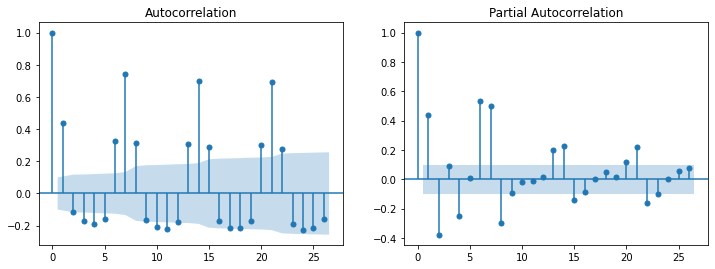

In [5]:
#Specify lags

plt.figure(figsize = (12, 9))
ax1 = plt.subplot2grid((2,2), (0,0))
ax2 = plt.subplot2grid((2,2), (0,1))
    
plot_acf(y, ax = ax1)
plot_pacf(y, ax = ax2)
plt.show()

In [7]:
#Data splitting

train = dff['Energy Consumption (kWh)'].loc['2019-11-01':'2020-09-03']
test = dff['Energy Consumption (kWh)'].loc['2020-09-04':'2020-11-19']

len(train), len(test), round(((len(test)/len(dff))*100), 2)

(308, 77, 19.95)

In [ ]:
#Saving training dataset

training_site = pd.DataFrame('CCC0611', index = train.index, columns = ['Site ID'])
training = pd.concat([train, training_site], axis = 1)
#len(training)
#training.to_csv('CCC0611_training_data.csv')

In [ ]:
plt.figure(figsize = (10, 8))
plt.plot(train, color = 'b')
plt.plot(test, color = 'orange')
plt.title('CCC0611 - Energy Consumption (kWh)')
plt.legend(['Train', 'Test'])
plt.show()

In [ ]:
train.hist()
plt.title('Count vs. kWh')


#Summary statistics

s = train.values
split = int(len(s)/2)
s1, s2 = s[0:split], s[split:]
mean1, mean2 = s1.mean(), s2.mean()
var1, var2 = s1.var(), s2.var()

print('Avg1 = %f, Avg2 = %f' % (mean1, mean2))
print('Var1 = %f, Var2 = %f' % (var1, var2))

In [ ]:
result = seasonal_decompose(train, period = 7)
fig = result.plot()
fig.set_size_inches(12, 8)

In [ ]:
#Statistical Test 1: Difference stationarity test 

def adfuller_test(serie, figsize = (12,4), plot = True, title = ""):
#    if plot:
#        serie.plot(figsize = figsize, title = title)
#        plt.show()
    #Dickey Fuller test on the first difference
    adf = adfuller(serie)
    output = pd.Series(adf[0:4], index = ['ADF Statistic', 'p-value', 'Used Lags', 'Number of comments used'])
#    output = round(output, 4)
    
    for key, value in adf[4].items():
        output["Critical Value (%s)" %key] = value
    return output

adfuller_test(train, title = ''), adfuller_test(train.diff().dropna(), title = '')

In [ ]:
#Statistical Test 2: Assumes the series is stationary; non-stationary if p-value < 5% or test statistic is above critical values
#Absence of unit root--> trend stationary 

def kpss_test(serie):
    kpss_input = kpss(serie)
    output = pd.Series(kpss_input[0:3], index = ['KPSS Statistic', 'p-value', 'Used Lags'])
#    output = round(output, 4)
    
    for key, value in kpss_input[3].items():
        output["Critical Value (%s)" %key] = value 
    return output

kpss_test(train), kpss_test(train.diff().dropna())

In [ ]:
#First Difference
train_1 = train.diff().dropna()

plt.figure(figsize = (10, 8))
plt.plot(train)
plt.plot(train_1, color = 'orange')
plt.title('CCC0611')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kWh)')
plt.legend(['Train', 'Differenced Train'])

In [ ]:
search_params = auto_arima(train, start_p = 1, start_q = 1, max_p = 3, max_q = 3, m = 12, start_P = 0, seasonal = True, d = 1, D = 1, 
                            trace = True, error_action = 'ignore', suppress_warnings = True, stepwise = True)

print("AIC=", search_params.aic())
print("BIC=", search_params.bic())

In [ ]:
model = sm.tsa.statespace.SARIMAX(train, order = (0, 1, 0), seasonal_order = (2, 1, 0, 7))
results = model.fit()

print(results.summary().tables[0])

In [ ]:
pred = results.get_forecast(steps = len(test))
pred_ci = pred.conf_int()

In [ ]:
forecast_data = pd.DataFrame(pred.predicted_mean, index = test.index, columns = ['Forecast'])
fig = pd.concat([test, forecast_data], axis = 1).plot(title = 'CCC0611')

In [ ]:
compare = pd.concat([test, pred_ci, forecast_data], axis = 1)
compare.head(30)

In [ ]:
def check_error(orig, fore):
    """This function generates performance metrics"""
    
    mse = mean_squared_error(orig, fore)
    rmse = round(sqrt(mse), 2)
    mape = round(np.mean(np.abs((orig - fore) / orig)) * 100, 2)
    metrics = [rmse, mape]
    
    print('RMSE = ', metrics[0])
    print('MAPE = ', metrics[1])


check_error(test, compare['Forecast']) #pred.predicted_mean

In [ ]:
results.plot_diagnostics(figsize = (16, 8))
plt.show()

In [ ]:
compare = pd.concat([test, forecast_data], axis = 1)
#compare.head(30)

In [ ]:
def plot_error(data, figsize = (14, 7)):
    '''
    '''
    
    plt.figure(figsize = figsize)
#    ax1 = plt.subplot2grid((2,2), (0,0))
    ax2 = plt.subplot2grid((2,2), (0,1))
    
    # Residual vs Predicted values
    ax2.scatter(data.iloc[:, 1], data.iloc[:, 2])
    ax2.set_xlabel('Forecasts')
    ax2.set_ylabel('Errors')
    ax2.set_title('Error versus Forecast')
      
    # Autocorrelation plot of the residual
    plot_acf(data.iloc[:, 2], lags = len(data.iloc[:, 2])-1, zero = False)
    plt.tight_layout()
    
    return plt.show()


resultsdf['Error'] = resultsdf['Forecast'] - resultsdf['Energy Consumption (kWh)']
#resultsdf.head()
plot_error(resultsdf)